### Trading WTI futures using Carry and its momentum - Description of the strategy we follow

In this notebook we implement the same strategies as the ones described in the notebook _WTI-Carry-Momentum-2023.ipynb_, i.e., carry along with carry momentum. Here, however, we focus on the one year time interval from June 2023 to June 2024. As before, our analysis is based on the 12 month spread $ C \left( 1,13\right) $ and the futures contracts are rolled on the last business day of each month, following [1].


[1] I. Bouchouev, Energy Quantamentals: Myths and Realities about Algorithmic Oil Traders, Oxford Institute for Energy Studies (2024).

## Read data for the time period from June 23 to June 24

Here we load the necessary Python libraries and download the WTI price data for the time interval of interest as well as the last business and trading days for every front month future contract.

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
#import time
import pandas_market_calendars as mcal

datos = pd.read_csv('data/datos_1_y_prior_to_20240613.csv')  
last_Day = pd.read_csv('data/last_Day_1_y_prior_to_20240613.csv')

In [5]:
display(type(datos.loc[0,'date']))
display(type(last_Day.lastBusinessDay.iloc[0]))
display(type(last_Day.lastTradingDay.iloc[0]))

str

str

str

### Convert dates from str to datetime

In [6]:
for ind in datos.index:
    datos.loc[ind,'date'] = dt.datetime.strptime(datos.loc[ind,'date'], '%Y-%m-%d').date()

display(datos.head())

for ind in last_Day.index:
    last_Day.loc[ind,'lastBusinessDay'] = dt.datetime.strptime(last_Day.loc[ind,'lastBusinessDay'], '%Y-%m-%d').date()
    last_Day.loc[ind,'lastTradingDay']  = dt.datetime.strptime(last_Day.loc[ind,'lastTradingDay'], '%Y-%m-%d').date()

display(last_Day.head())

,date,FrontMonth,SecondMonth,ThirteenthMonth,FourteenthMonth
0,2023-03-21,69.67,69.77,67.09,66.90
1,2023-03-22,70.90,71.02,67.86,67.61
2,2023-03-23,69.96,70.12,67.42,67.18
3,2023-03-24,69.26,69.41,66.96,66.77
4,2023-03-27,72.81,72.93,69.80,69.53


,lastBusinessDay,lastTradingDay
0,2023-03-31,2023-04-20
1,2023-04-28,2023-05-22
2,2023-05-31,2023-06-20
3,2023-06-30,2023-07-20
4,2023-07-31,2023-08-22


### Insert a duplicate of the first row in the last_Day dataframe

In [7]:
last_Day.info()

r1 = []
r1.insert(0, {'lastBusinessDay': last_Day.loc[0,'lastBusinessDay'], 'lastTradingDay': last_Day.loc[0,'lastTradingDay']})

last_Day = pd.concat([pd.DataFrame(r1), last_Day], ignore_index=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   lastBusinessDay  15 non-null     object
 1   lastTradingDay   15 non-null     object
dtypes: object(2)
memory usage: 368.0+ bytes


### Compute synthetic front month and thirteenth month contracts upon calculating the cumulative roll differential

In [10]:
datos['FrontSynthetic'] = 0
datos['ThirteenthSynthetic'] = 0
datos['Carry'] = 0
datos['CarrySMA20'] = 0
datos['CarrySMA5'] = 0
datos['CarryMom'] = 0

display(datos.tail())

,date,FrontMonth,SecondMonth,ThirteenthMonth,FourteenthMonth,FrontSynthetic,ThirteenthSynthetic,Carry,CarrySMA20,CarrySMA5,CarryMom
314,2024-06-07,75.53,75.22,71.08,70.79,0,0,0,0,0,0
315,2024-06-10,77.74,77.33,72.47,72.14,0,0,0,0,0,0
316,2024-06-11,77.90,77.55,72.80,72.47,0,0,0,0,0,0
317,2024-06-12,78.50,78.15,73.19,72.85,0,0,0,0,0,0
318,2024-06-13,78.62,78.26,73.35,73.00,0,0,0,0,0,0


In [11]:
# Create synthetic contract

roll_diff_F = 0
roll_diff_T = 0

# index of date used to compute synthetic contracts (could also be today or last date of the series)
indE = 318    # 13-06-2024
print(datos.loc[indE,'date'])

# find index of previous closer lastTradingDay
for indT in range(last_Day.index[-1],-1,-1):
    if datos.loc[indE,'date'] > last_Day.loc[indT,'lastTradingDay']:
        break

# find closer lastBusinessDay
indB = indT + 1

if datos.loc[indE,'date'] == last_Day.loc[indB,'lastBusinessDay']:
    roll_diff_F = roll_diff_F + datos.loc[indE,'SecondMonth']     - datos.loc[indE,'FrontMonth']
    roll_diff_T = roll_diff_T + datos.loc[indE,'FourteenthMonth'] - datos.loc[indE,'ThirteenthMonth']
    datos.loc[indE,'FrontSynthetic'] = datos.loc[indE,'FrontMonth'] + roll_diff_F
    datos.loc[indE,'ThirteenthSynthetic'] = datos.loc[indE,'ThirteenthMonth'] + roll_diff_T
elif datos.loc[indE,'date'] < last_Day.loc[indB,'lastBusinessDay']:
    datos.loc[indE,'FrontSynthetic'] = datos.loc[indE,'FrontMonth'] + roll_diff_F
    datos.loc[indE,'ThirteenthSynthetic'] = datos.loc[indE,'ThirteenthMonth'] + roll_diff_T
else:
    datos.loc[indE,'FrontSynthetic'] = datos.loc[indE,'SecondMonth'] + roll_diff_F
    datos.loc[indE,'ThirteenthSynthetic'] = datos.loc[indE,'FourteenthMonth'] + roll_diff_T

for ind in range(indE-1,-1,-1):
    if datos.loc[ind,'date'] == last_Day.loc[indT,'lastTradingDay']:
        indT = indT - 1
        indB = indB - 1
        datos.loc[ind,'FrontSynthetic'] = datos.loc[ind,'SecondMonth'] + roll_diff_F
        datos.loc[ind,'ThirteenthSynthetic'] = datos.loc[ind,'FourteenthMonth'] + roll_diff_T
    else:
        if datos.loc[ind,'date'] == last_Day.loc[indB,'lastBusinessDay']:
            roll_diff_F = roll_diff_F + datos.loc[ind,'SecondMonth']     - datos.loc[ind,'FrontMonth']
            roll_diff_T = roll_diff_T + datos.loc[ind,'FourteenthMonth'] - datos.loc[ind,'ThirteenthMonth']
            datos.loc[ind,'FrontSynthetic'] = datos.loc[ind,'FrontMonth'] + roll_diff_F
            datos.loc[ind,'ThirteenthSynthetic'] = datos.loc[ind,'ThirteenthMonth'] + roll_diff_T
        elif datos.loc[ind,'date'] < last_Day.loc[indB,'lastBusinessDay']:
            datos.loc[ind,'FrontSynthetic'] = datos.loc[ind,'FrontMonth'] + roll_diff_F
            datos.loc[ind,'ThirteenthSynthetic'] = datos.loc[ind,'ThirteenthMonth'] + roll_diff_T
        else:
            datos.loc[ind,'FrontSynthetic'] = datos.loc[ind,'SecondMonth'] + roll_diff_F
            datos.loc[ind,'ThirteenthSynthetic'] = datos.loc[ind,'FourteenthMonth'] + roll_diff_T
        
display(datos.head())
    


2024-06-13


,date,FrontMonth,SecondMonth,ThirteenthMonth,FourteenthMonth,FrontSynthetic,ThirteenthSynthetic,Carry,CarrySMA20,CarrySMA5,CarryMom
0,2023-03-21,69.67,69.77,67.09,66.90,63.93,61.66,0,0,0,0
1,2023-03-22,70.90,71.02,67.86,67.61,65.16,62.43,0,0,0,0
2,2023-03-23,69.96,70.12,67.42,67.18,64.22,61.99,0,0,0,0
3,2023-03-24,69.26,69.41,66.96,66.77,63.52,61.53,0,0,0,0
4,2023-03-27,72.81,72.93,69.80,69.53,67.07,64.37,0,0,0,0


In [31]:
datos['Carry'] = datos['FrontSynthetic'] - datos['ThirteenthSynthetic']

#datos['Carry'] = datos['FrontMonth'] - datos['ThirteenthMonth']

datos['CarrySMA20'] = datos['Carry'].rolling(20).mean()

datos['CarrySMA5'] = datos['Carry'].rolling(5).mean()

datos['CarryMom'] = datos['Carry'] - datos['CarrySMA20']

display(datos.tail())


,date,FrontMonth,SecondMonth,ThirteenthMonth,FourteenthMonth,FrontSynthetic,ThirteenthSynthetic,Carry,CarrySMA20,CarrySMA5,CarryMom
314,2024-06-07,75.53,75.22,71.08,70.79,75.22,70.79,4.43,5.0575,4.170,-0.6275
315,2024-06-10,77.74,77.33,72.47,72.14,77.33,72.14,5.19,5.0290,4.510,0.1610
316,2024-06-11,77.90,77.55,72.80,72.47,77.55,72.47,5.08,5.0200,4.774,0.0600
317,2024-06-12,78.50,78.15,73.19,72.85,78.15,72.85,5.30,5.0090,4.956,0.2910
318,2024-06-13,78.62,78.26,73.35,73.00,78.26,73.00,5.26,4.9920,5.052,0.2680


## WTI Carry Strategy

### Graph of WTI price against the annual Carry

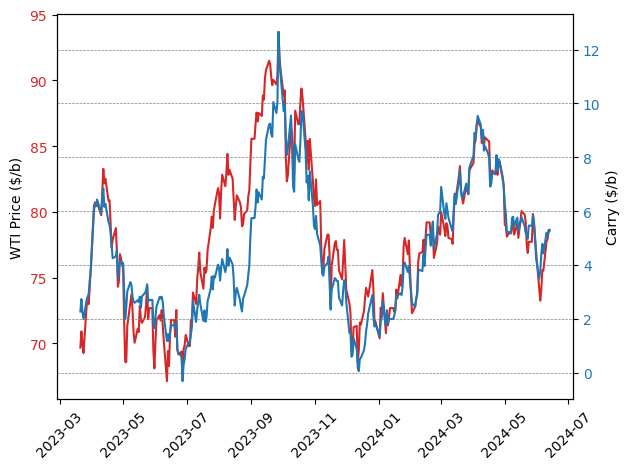

In [32]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('WTI Price ($/b)', rotation=90)
ax1.plot(datos['date'].iloc[:], datos['FrontMonth'].iloc[:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45)


ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Carry ($/b)', rotation=90)
ax2.plot(datos['date'].iloc[:], datos['Carry'].iloc[:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

fig.tight_layout()
plt.show()

In [33]:
print(datos.loc[59,'date'])
print(datos.loc[318,'date'])

2023-06-13
2024-06-13


### Backtesting the Carry strategy

In [34]:
# WTI Carry strategy with rollover on the last business day of each month

import numpy as np

# these two indices determine initial and final dates for the analysis
ind = 59
indE = 318   # End date

pos = 0
open_p = -1
close_p = -1
PnL = [0]
logPnL = [0]
cross_index = []

open_p = datos.iloc[ind].FrontSynthetic
if datos.iloc[ind].Carry > 0:
    pos = 1
else:
    pos = -1
cross_index.append(ind)

# change position when Carry changes sign
for index in datos.iloc[ind+1:indE+1].iterrows():
    indy = index[0]
    
    close_p = datos['FrontSynthetic'].iloc[indy]
    PnL.append(pos*(close_p-open_p))
    logPnL.append(pos*np.log(close_p/open_p))
    open_p = close_p
    
    if datos.iloc[indy].Carry*datos.iloc[indy-1].Carry < 0:
        
        if datos.iloc[indy].Carry > 0:
            pos = 1
        else:
            pos = -1
        cross_index.append(indy)

results = pd.DataFrame(
                {'date': datos['date'].iloc[ind:indE+1],
                 'PnL': PnL,
                 'logPnL': logPnL
                })
results.reset_index(drop=True, inplace=True)
display(results.head())

print('Total PnL in $/b for the given time period:')
print('%.2f' % results.PnL.sum())

logPnL_sum = results.logPnL.sum() * 100

print('Total log-return (%) for the given time period:')
print('%.2f' % logPnL_sum)
        
    

,date,PnL,logPnL
0,2023-06-13,0.00,0.000000
1,2023-06-14,-1.12,-0.017730
2,2023-06-15,2.35,0.036847
3,2023-06-16,1.12,0.017094
4,2023-06-19,0.00,0.000000


Total PnL in $/b for the given time period:
10.81
Total log-return (%) for the given time period:
14.61


### Obtain results for every month in the time interval of interest

In [35]:
results.date = pd.to_datetime(results.date)
PnL_monthly = results.groupby([results['date'].dt.year.rename('year'), results['date'].dt.month_name().rename('month')], sort=False)[['PnL','logPnL']].sum().reset_index()
PnL_monthly['Month'] = pd.to_datetime(PnL_monthly['year'].astype(str)  + PnL_monthly['month'], format='%Y%B')

PnL_monthly.drop([0], inplace=True)
PnL_monthly.reset_index(inplace=True, drop=True)
PnL_monthly['logPnL_c'] = ''
PnL_monthly.loc[0,'logPnL_c'] = PnL_monthly.loc[0,'logPnL'] * 100
for ind in PnL_monthly.index[1:]:
    PnL_monthly.loc[ind,'logPnL_c'] = PnL_monthly.loc[ind-1,'logPnL_c'] + PnL_monthly.loc[ind,'logPnL'] * 100
    
display(PnL_monthly)


,year,month,PnL,logPnL,Month,logPnL_c
0,2023,July,11.02,0.157079,2023-07-01,15.707894
1,2023,August,2.31,0.030016,2023-08-01,18.709484
2,2023,September,7.83,0.095520,2023-09-01,28.261446
3,2023,October,-7.78,-0.094880,2023-10-01,18.773467
4,2023,November,-4.54,-0.059833,2023-11-01,12.790128
5,2023,December,-4.40,-0.061618,2023-12-01,6.628302
6,2024,January,4.01,0.056307,2024-01-01,12.259045
7,2024,February,2.55,0.034225,2024-02-01,15.681509
8,2024,March,5.72,0.072759,2024-03-01,22.957444
9,2024,April,-0.49,-0.006030,2024-04-01,22.354477


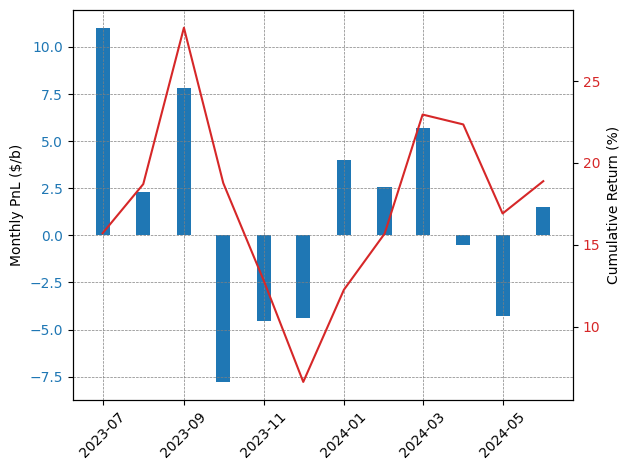

In [36]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('Monthly PnL ($/b)', rotation=90)
ax1.bar(PnL_monthly.Month, PnL_monthly.PnL, width=10.8)
ax1.tick_params(axis='y', labelcolor=color)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation=45)


ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Cumulative Return (%)', rotation=90)
ax2.plot(PnL_monthly.Month, PnL_monthly.logPnL_c, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([-20, 20])


fig.tight_layout()
plt.show()

### Total real PnL after commissions in the IBKR platform

In [37]:
## number of MCL contracts traded
n_mcl = 3

# price of 1 MCL contract
pr_mcl = .77

# total PnL (in $) after commissions on IBKR before taxes
print('Total PnL (in $) after commissions on IBKR platform for the given time period:')
# Here we don't take into account the rolling of futures.
total_PnL = results.PnL.sum()*100*n_mcl - pr_mcl*n_mcl*2*len(cross_index) - 1*len(cross_index)
print('%.3f' % total_PnL)

Total PnL (in $) after commissions on IBKR platform for the given time period:
3226.140


## WTI Carry-Momentum Strategy

### Graph of WTI price against the 20-day momentum of Carry

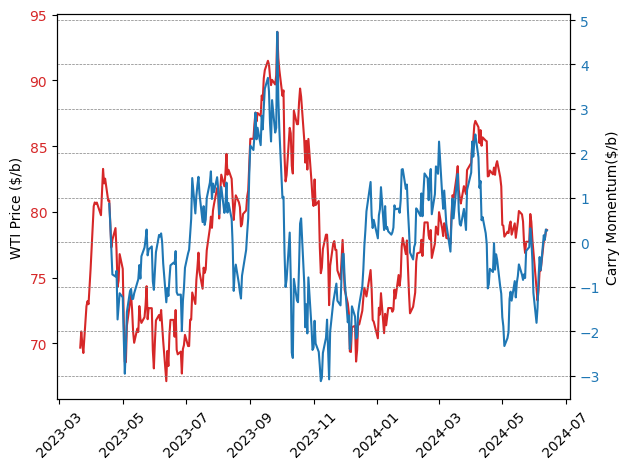

In [38]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('WTI Price ($/b)', rotation=90)
ax1.plot(datos['date'].iloc[:], datos['FrontMonth'].iloc[:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45)


ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Carry Momentum($/b)', rotation=90)
ax2.plot(datos['date'].iloc[:], datos['CarryMom'].iloc[:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

fig.tight_layout()
plt.show()

### Backtesting the Carry-Momentum strategy

In [39]:
# WTI Carry strategy with rollover on the last business day of each month

import numpy as np

# these two indices determine initial and final dates for the analysis
ind = 59
indE = 318   # End date

pos = 0
open_p = -1
close_p = -1
PnL = [0]
logPnL = [0]
cross_index = []

open_p = datos.iloc[ind].FrontSynthetic
if datos.iloc[ind].CarryMom > 0:
    pos = 1
else:
    pos = -1
cross_index.append(ind)

# change position when Carry changes sign
for index in datos.iloc[ind+1:indE+1].iterrows():
    indy = index[0]
    
    close_p = datos['FrontSynthetic'].iloc[indy]
    PnL.append(pos*(close_p-open_p))
    logPnL.append(pos*np.log(close_p/open_p))
    open_p = close_p
    
    if datos.iloc[indy].CarryMom*datos.iloc[indy-1].CarryMom < 0:
        
        if datos.iloc[indy].CarryMom > 0:
            pos = 1
        else:
            pos = -1
        cross_index.append(indy)

results = pd.DataFrame(
                {'date': datos['date'].iloc[ind:indE+1],
                 'PnL': PnL,
                 'logPnL': logPnL
                })
results.reset_index(drop=True, inplace=True)
display(results.head())

print('Total PnL in $/b for the given time period:')
print('%.2f' % results.PnL.sum())

logPnL_sum = results.logPnL.sum() * 100

print('Total log-return (%) for the given time period:')
print('%.2f' % logPnL_sum)
        
    

,date,PnL,logPnL
0,2023-06-13,0.00,0.000000
1,2023-06-14,1.12,0.017730
2,2023-06-15,-2.35,-0.036847
3,2023-06-16,-1.12,-0.017094
4,2023-06-19,-0.00,-0.000000


Total PnL in $/b for the given time period:
16.67
Total log-return (%) for the given time period:
21.93


### Obtain results for every month in the time interval of interest

In [22]:
results.date = pd.to_datetime(results.date)
PnL_monthly = results.groupby([results['date'].dt.year.rename('year'), results['date'].dt.month_name().rename('month')], sort=False)[['PnL','logPnL']].sum().reset_index()
PnL_monthly['Month'] = pd.to_datetime(PnL_monthly['year'].astype(str)  + PnL_monthly['month'], format='%Y%B')

PnL_monthly.drop([0], inplace=True)
PnL_monthly.reset_index(inplace=True, drop=True)
PnL_monthly['logPnL_c'] = ''
PnL_monthly.loc[0,'logPnL_c'] = PnL_monthly.loc[0,'logPnL'] * 100
for ind in PnL_monthly.index[1:]:
    PnL_monthly.loc[ind,'logPnL_c'] = PnL_monthly.loc[ind-1,'logPnL_c'] + PnL_monthly.loc[ind,'logPnL'] * 100
    
display(PnL_monthly)

,year,month,PnL,logPnL,Month,logPnL_c
0,2023,July,8.82,0.123408,2023-07-01,12.340811
1,2023,August,0.99,0.012491,2023-08-01,13.589867
2,2023,September,7.83,0.095520,2023-09-01,23.141829
3,2023,October,-11.42,-0.136157,2023-10-01,9.526126
4,2023,November,4.54,0.059833,2023-11-01,15.509465
5,2023,December,-0.08,-0.002069,2023-12-01,15.302593
6,2024,January,4.01,0.056307,2024-01-01,20.933336
7,2024,February,-5.23,-0.074196,2024-02-01,13.513716
8,2024,March,2.18,0.026637,2024-03-01,16.17737
9,2024,April,5.31,0.064306,2024-04-01,22.607988


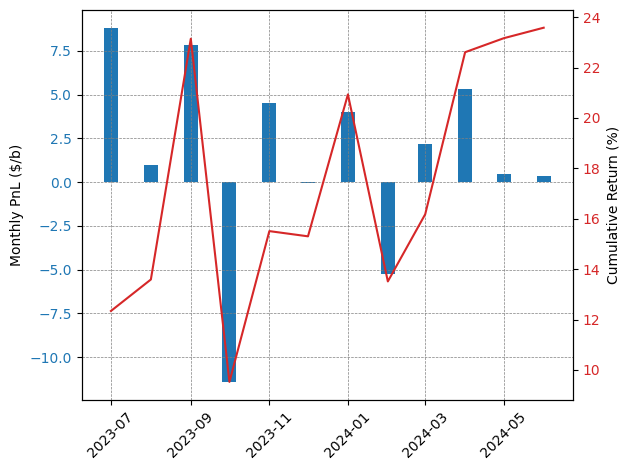

In [23]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('Monthly PnL ($/b)', rotation=90)
ax1.bar(PnL_monthly.Month, PnL_monthly.PnL, width=10.8)
ax1.tick_params(axis='y', labelcolor=color)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation=45)


ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Cumulative Return (%)', rotation=90)
ax2.plot(PnL_monthly.Month, PnL_monthly.logPnL_c, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([-20, 20])


fig.tight_layout()
plt.show()

### Total real PnL after commissions in the IBKR platform

In [24]:
## number of MCL contracts traded
n_mcl = 3

# price of 1 MCL contract
pr_mcl = .77

# total PnL (in $) after commissions on IBKR before taxes
print('Total PnL (in $) after commissions on IBKR platform for the given time period:')
# Here we don't take into account the rolling of futures.
total_PnL = results.PnL.sum()*100*n_mcl - pr_mcl*n_mcl*2*len(cross_index) - 1*len(cross_index)
print('%.3f' % total_PnL)

Total PnL (in $) after commissions on IBKR platform for the given time period:
4899.840
